In [10]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn.functional as F

from utils_notebook import load_enroll, load_test

In [11]:
def analyze(db):
    acc = len(db.query('true_user == pred_cosine')) / len(db)
    
    avg_correct =  db.query('true_user == pred_cosine')['cosine_score'].mean()
    avg_wrong = db.query('true_user != pred_cosine')['cosine_score'].mean()
    
    print(f'Accuracy: {acc}\n')
    print(f'Correct prediction (avg score): {avg_correct}')
    print(f'Wrong prediction (avg score): {avg_wrong}')
    
    idx_wrong = np.where(db['pred_cosine'] != db['true_user'])
    
    return idx_wrong

In [26]:
def plot_cmap(df, n, users_to_plot=None):
    
    # Select n random users
    if users_to_plot is None:
        users_to_plot = random.sample(list(df.columns), n)
    else:
        users_to_plot = list(users_to_plot)
    
    # Select from df
    df_to_plot = df.loc[users_to_plot][users_to_plot]
    
    # Plot heat map
    # Note: remove vmin, vmax to normalize between samples
    ax = sns.heatmap(df_to_plot, linewidth=1, cmap='viridis', vmin=-1, vmax=1)
    ax.set_title("Cosine similarity")
    plt.show()
    
    
    # Plot distribution
    wrong = df_to_plot.mask(np.equal(*np.indices(df_to_plot.shape))).to_numpy().flatten()
    correct = pd.Series(np.diag(df_to_plot))
    
    sns.distplot(wrong, hist=False, norm_hist=False, kde=True, label="Different")
    sns.distplot(correct, hist=False, norm_hist=False, kde=True, label="Same")
    plt.legend()

    axes = plt.gca()
    axes.set_xlim([-1,+1])

In [27]:
def main(base_path):
    enroll_embd = load_enroll(os.path.join(base_path, 'enroll_samples.csv'))
    users = list(enroll_embd.keys())
    
    test_embd = load_test(os.path.join(base_path, 'test_samples.csv'))
    
    # Initialize DFs
    
    DB_rows = [] 
    tot = {}
    
    # Iterate

    for to_test, test_user in test_embd:

        max_score = -10**8
        min_score = 10**8
        best_spk = None

        if test_user not in tot.keys():
            tot[test_user]= {'scores': np.zeros(50), 
                             'count': 0}

        scores = []
        for enroll_user in users:
            reference = enroll_embd[enroll_user]

            score = F.cosine_similarity(reference, to_test)
            score = score[0].data.cpu().numpy()

            scores.append(score)

            mse = ((to_test - reference) ** 2).sum().numpy()

            #print(test_user, enroll_user, score)

            if score > max_score:
                best_spk = enroll_user
                max_score = score

            if mse < min_score:
                best_mse = enroll_user
                min_score = mse
                #print('Best user updated!')

        tot[test_user]['scores'] += np.array(scores) 
        tot[test_user]['count'] += 1

        DB_rows.append([test_user, best_spk, max_score, best_mse, min_score])


    # Prepare df
    DB= pd.DataFrame(DB_rows, columns=['true_user', 'pred_cosine', 'cosine_score', 'pred_mse', 'mse_score'])
    
    norm_dict = {k:tot[k]['scores']/tot[k]['count'] for k in tot.keys()}
    df = pd.DataFrame.from_dict(norm_dict, orient='index', columns=users)  # rows reperesnet the true ueser, columns the score of the predicted one
    
    return DB, df

## Trained with contrastive loss

In [28]:
path_verification = '/cas/DeepLearn/elperu/tmp/speech_datasets/LibriSpeech/embd_verification/'
DB, df = main(path_verification)

In [29]:
idx_wrong = analyze(DB)

Accuracy: 0.8128205128205128

Correct prediction (avg score): 0.9104196446175079
Wrong prediction (avg score): 0.8493028614619007


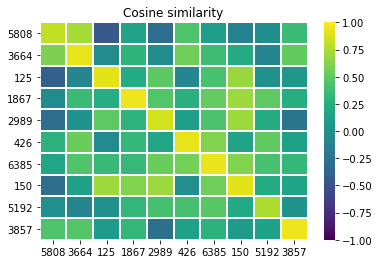

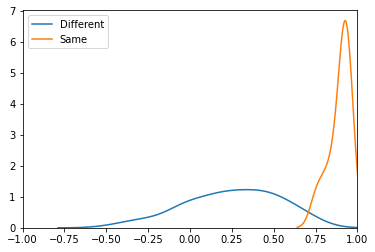

In [30]:
plot_cmap(df, 10, df.columns[:10])

## Trained with cross-entropy

In [31]:
path_identification = '/cas/DeepLearn/elperu/tmp/speech_datasets/LibriSpeech/embd_identification/'
DB_2, df_2 = main(path_identification)

In [32]:
idx_wrong_2 = analyze(DB_2)

Accuracy: 0.8958974358974359

Correct prediction (avg score): 0.9939929807124713
Wrong prediction (avg score): 0.9866936594394627


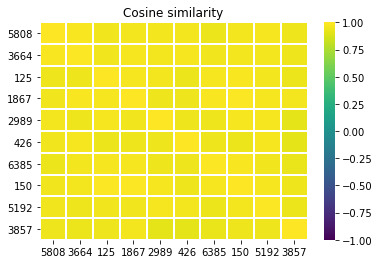

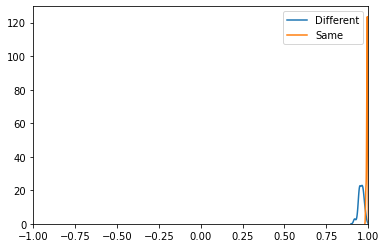

In [33]:
plot_cmap(df_2, 10, df.columns[:10])

# Equal Error Rate

$$TPR =\frac{TP}{P} = \frac{TP}{TP+FN}$$
$$FPR = \frac{FP}{N} = \frac{FP}{TN+FP}  $$
- False Accptance Rate = False Positive Rate <br>
- False Rejection Rate = False Negative Rate =1 - True Positive Rate

In [34]:
import scipy
import scipy.stats as stats

In [35]:
wrong = df.mask(np.equal(*np.indices(df.shape))).to_numpy().flatten()
correct = pd.Series(np.diag(df))

In [36]:
def compute_EER(kde_w, kde_c):
    
    n = 200
    tau = np.linspace(-1, 1, num=n)

    FAR = []
    FRR = []

    for t in tau:
        false_acceptance = kde_w.integrate_box_1d(t, np.inf)
        false_rejections = kde_c.integrate_box_1d(-np.inf, t)

        FAR.append(false_acceptance)
        FRR.append(false_rejections)
    
    FAR = np.array(FAR)
    FRR = np.array(FRR)
    
    # Compute EER
    idx = np.argwhere(np.diff(np.sign(FAR - FRR))).flatten()
    y_eer = 0.5 * (FAR[idx] + FRR[idx])
    x_eer = tau[idx]
        
    return FAR, FRR, tau, [x_eer, y_eer]

Correct: 0.9753342907775404
Wrong: 0.9997165603072347


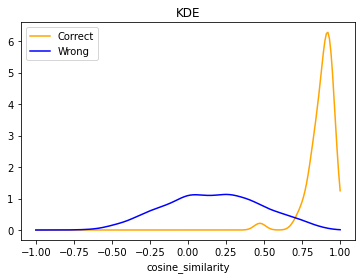

In [37]:
wrong_ = wrong[~np.isnan(wrong)]

kde_c = stats.gaussian_kde(correct)
kde_w = stats.gaussian_kde(wrong_)

# Check the sum over [-1, +1]
print(f'Correct: {kde_c.integrate_box_1d(-1,1)}')
print(f'Wrong: {kde_w.integrate_box_1d(-1,1)}')

# Evaluate the distributions in the interval [-1, +1]
x = np.linspace(-1,1,num=200)
y_c = kde_c(x)
y_w = kde_w(x)



######################################################
## Plot 1
# Plot the two distibutions as they are

plt.plot(x, y_c, color='orange', label='Correct')
plt.plot(x, y_w, color='blue', label='Wrong')
plt.legend()
plt.title('KDE')
plt.xlabel('cosine_similarity')
plt.show()

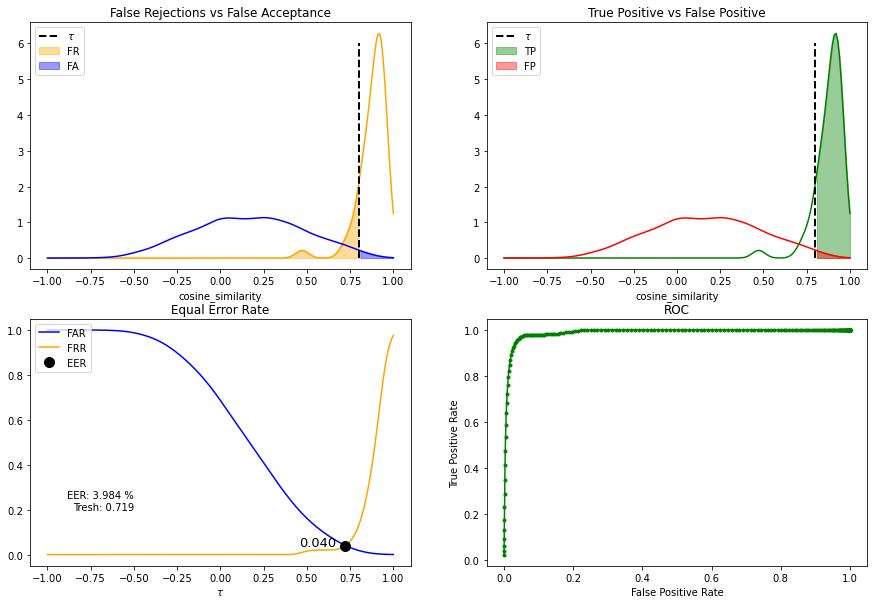

In [38]:
########################################################
fig = plt.figure(figsize=(15, 10))
## Plot 2
# Decide a threshold plot FAR and FRR
tau = 0.8
idx = x < tau
plt.subplot(2,2,1)
plt.plot(x, y_c, color='orange')#, label='Correct')
plt.fill_between(x[idx], 0, y_c[idx], color='orange', alpha=0.4, label='FR')
plt.plot(x, y_w, color='blue')#, label='Wrong')
plt.fill_between(x[~idx], 0, y_w[~idx], color='blue', alpha=0.4, label='FA')
plt.plot([tau, tau], [0, 6], 'k--', linewidth=2, label=r'$\tau$')  # plot x and y using blue circle markers
plt.legend()
plt.title('False Rejections vs False Acceptance')
plt.xlabel('cosine_similarity')


#############################################################
## Plot 3
# Decide a threshold plot TP vs FP
tau = 0.8
idx = x > tau
plt.subplot(2,2,2)
plt.plot(x, y_c, color='green')#, label='Correct')
plt.fill_between(x[idx], 0, y_c[idx], color='green', alpha=0.4, label='TP')
plt.plot(x, y_w, color='red')#, label='Wrong')
plt.fill_between(x[idx], 0, y_w[idx], color='red', alpha=0.4, label='FP')
plt.plot([tau, tau], [0, 6], 'k--', linewidth=2, label=r'$\tau$')  # plot x and y using blue circle markers
plt.legend()
plt.title('True Positive vs False Positive')
plt.xlabel('cosine_similarity')


#########################################################
## Plot 4
# Compute EER
far, frr, t, eer = compute_EER(kde_w, kde_c)
plt.subplot(2,2,3)
plt.plot(t, far, color='blue', label='FAR')
plt.plot(t, frr, color='orange', label='FRR')

plt.plot(eer[0], eer[1], 'ko', markersize=10, label='EER')
plt.text(eer[0] - 0.05, eer[1], f'{eer[1][0] :.3f}', fontsize=13, horizontalalignment='right')

plt.text(-.5, 0.2, f'EER: {eer[1][0] * 100 :.3f} %\nTresh: {eer[0][0] :.3f}', fontsize=10, horizontalalignment='right')


plt.legend(loc='upper left')
plt.title('Equal Error Rate')
plt.xlabel(r'$\tau$')
#########################################################
## Plot 5
# Plot ROC
tpr = 1. - frr
plt.subplot(2,2,4)
plt.plot(far[::-1], tpr[::-1], 'green', marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')


plt.show()
#print('\n\n')
#print(f'EER: {eer[1][0] * 100 :.3f} %')
#print(f'Tresh: {eer[0][0] :.3f}')

### Compute all the metrics with sklearn

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score

In [40]:
# Concatenate scores
y_score = np.concatenate([wrong_, correct])

# Create labels, -1 for wrong scores, +1 for correct scores
neg_labels = -1 * np.ones(wrong_.shape)
pos_labels = 1 * np.ones(correct.shape)
y_true = np.concatenate([neg_labels, pos_labels])

In [41]:
print(y_true.shape)
print(y_score.shape)

(2500,)
(2500,)


In [42]:
# Compute metrics
fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
AUC = roc_auc_score(y_true, y_score, average='macro', sample_weight=None)
AP = average_precision_score(y_true, y_score, average='macro', sample_weight=None)

# Calculating EER
intersect_x = fpr[np.abs(fpr - (1 - tpr)).argmin(0)]
EER = intersect_x
miss = 1 - fpr
false = 1 - tpr

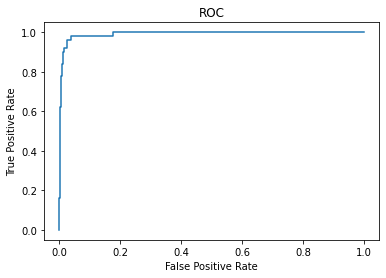


Area Under Curve: 0.992


In [43]:
# Plot ROC
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC')
plt.show()

print(f'\nArea Under Curve: {AUC :.3f}')

In [44]:
print(EER)
print(thresholds[np.where(fpr == intersect_x)])

0.03877551020408163
[0.71628087 0.71617758]
